<a href="https://colab.research.google.com/github/amisha-shrivastava/action_recognition_model/blob/main/my_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import os
import cv2
import math
import random
import pafy
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *

In [95]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential  #API to create model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

**Analysing Data:**
Picking a random video from 20 randomly choosen classes, diplaying first frame of each video with assosiated label

['PullUps', 'RopeClimbing', 'Punch', 'PlayingViolin', 'JumpingJack', 'PommelHorse', 'PlayingPiano', 'Nunchucks', 'SalsaSpin', 'PushUps', 'JugglingBalls', 'PoleVault', 'BaseballPitch', 'Diving', 'Drumming', 'SkateBoarding', 'BenchPress', 'CleanAndJerk', 'Skiing', 'TennisSwing', 'Swing', 'TrampolineJumping', 'MilitaryParade', 'HulaHoop', 'YoYo', 'JumpRope', 'TaiChi', 'WalkingWithDog', 'VolleyballSpiking', 'Basketball', 'PlayingTabla', 'Rowing', 'Biking', 'Mixing', 'PlayingGuitar', 'HighJump', 'Fencing', 'GolfSwing', 'PizzaTossing', 'ThrowDiscus', 'Lunges', 'Skijet', 'BreastStroke', 'Kayaking', 'SoccerJuggling', 'RockClimbingIndoor', 'Billiards', 'JavelinThrow', 'HorseRace', 'HorseRiding']


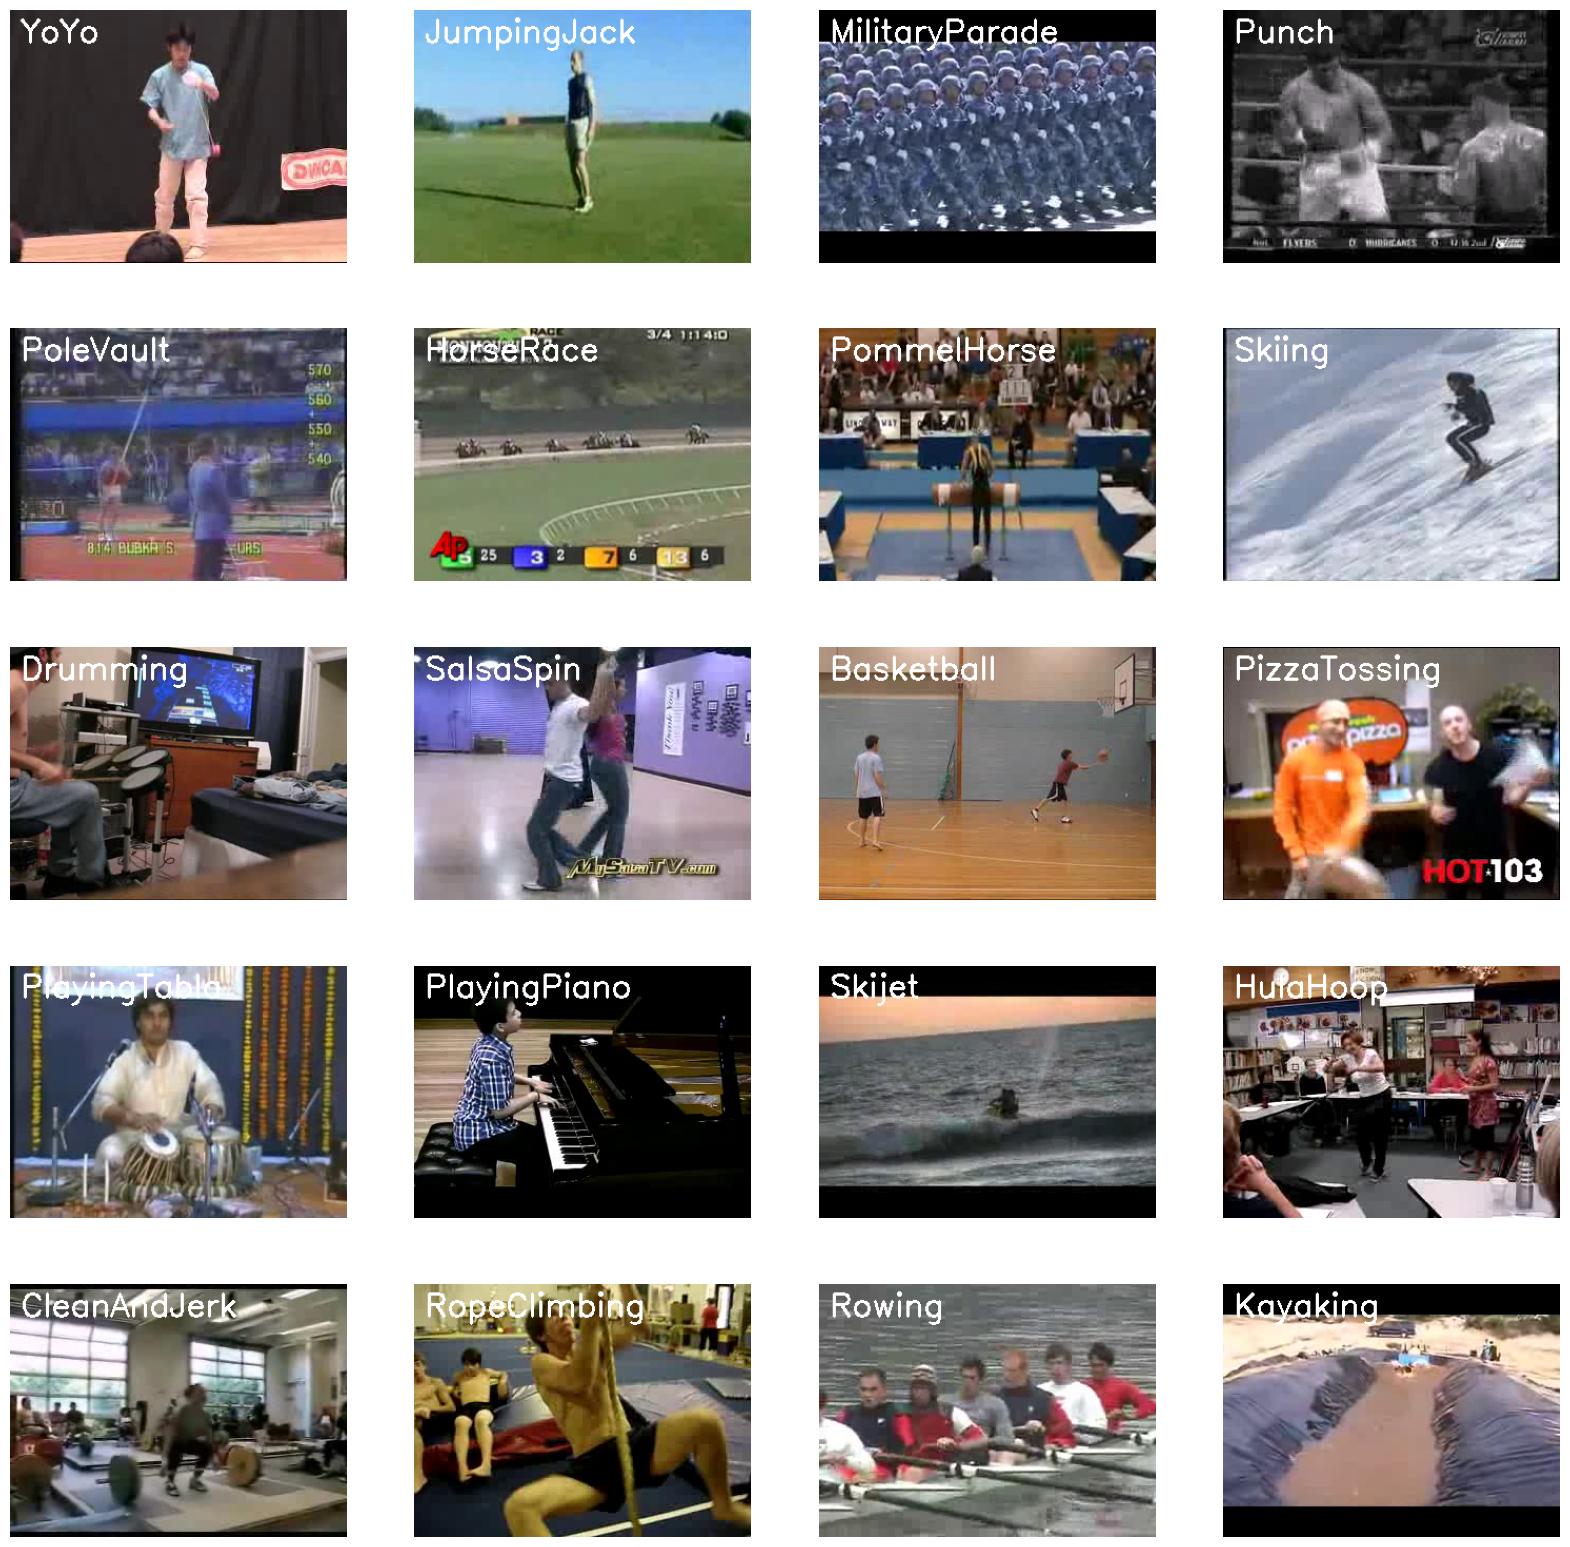

In [117]:

plt.figure(figsize = (20, 20))
all_classes_names = os.listdir('UCF50')
print(all_classes_names)

random_range = random.sample(range(len(all_classes_names)), 20)


for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

**PREPROCESSING DATASET**

**EXTRACT, RESIZE AND NORMALIZE**

In [98]:

IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = "UCF50"

CLASSES_LIST = ["SkateBoarding", "MilitaryParade", "Swing", "PlayingGuitar"]

In [99]:
def frames_extraction(video_path):

    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)).
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [100]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)


    features = np.asarray(features)
    labels = np.array(labels)


    return features, labels, video_files_paths

In [101]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: SkateBoarding
Extracting Data of Class: MilitaryParade
Extracting Data of Class: Swing
Extracting Data of Class: PlayingGuitar


In [102]:
one_hot_encoded_labels = to_categorical(labels)

In [103]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True)

In [104]:
def create_LRCN_model():

    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))


    model.summary()

    return model

In [105]:

LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 20, 4, 4, 32)     

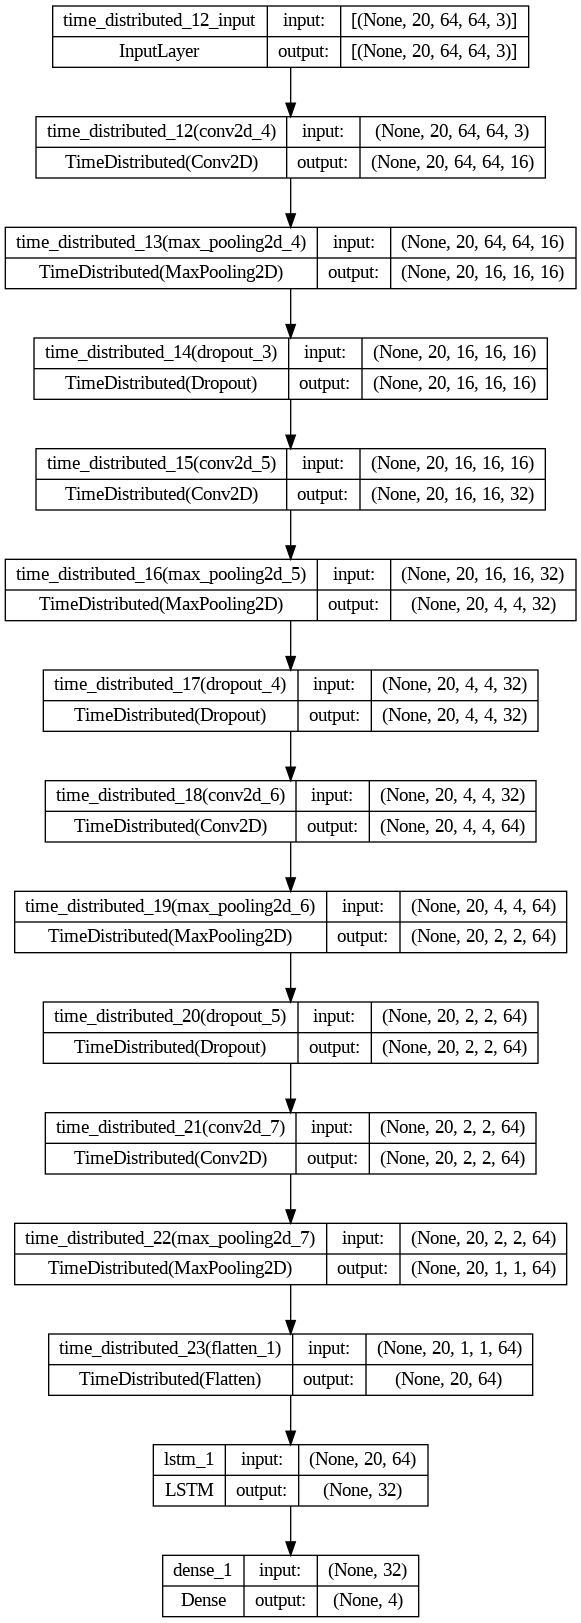

In [106]:

plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [108]:
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 40, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2)

Epoch 1/40
82/82 [==============================] - 19s 188ms/step - loss: 1.3663 - accuracy: 0.3037 - val_loss: 1.3016 - val_accuracy: 0.3902
Epoch 2/40
82/82 [==============================] - 15s 180ms/step - loss: 1.0611 - accuracy: 0.5215 - val_loss: 0.8548 - val_accuracy: 0.7561
Epoch 3/40
82/82 [==============================] - 14s 175ms/step - loss: 0.7668 - accuracy: 0.7117 - val_loss: 1.0651 - val_accuracy: 0.5488
Epoch 4/40
82/82 [==============================] - 15s 180ms/step - loss: 0.5590 - accuracy: 0.7822 - val_loss: 0.4902 - val_accuracy: 0.8537
Epoch 5/40
82/82 [==============================] - 15s 181ms/step - loss: 0.4428 - accuracy: 0.8282 - val_loss: 0.3754 - val_accuracy: 0.8659
Epoch 6/40
82/82 [==============================] - 14s 177ms/step - loss: 0.3867 - accuracy: 0.8436 - val_loss: 0.3422 - val_accuracy: 0.9146
Epoch 7/40
82/82 [==============================] - 15s 178ms/step - loss: 0.3506 - accuracy: 0.8926 - val_loss: 0.4137 - val_accuracy: 0.8537

In [109]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

5/5 [==============================] - 3s 463ms/step - loss: 0.3133 - accuracy: 0.9118


In [110]:

model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

  saving_api.save_model(



In [111]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))


    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)


    plt.title(str(plot_name))

    plt.legend()

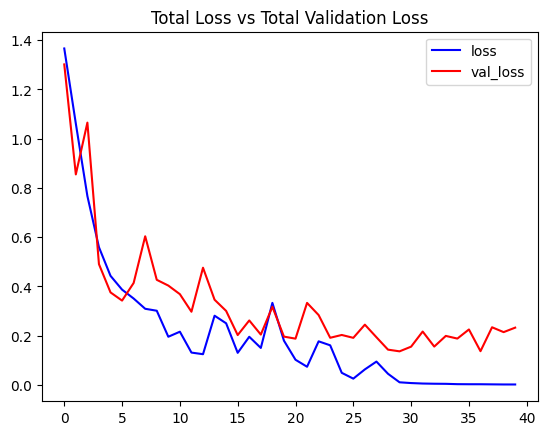

In [112]:

plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


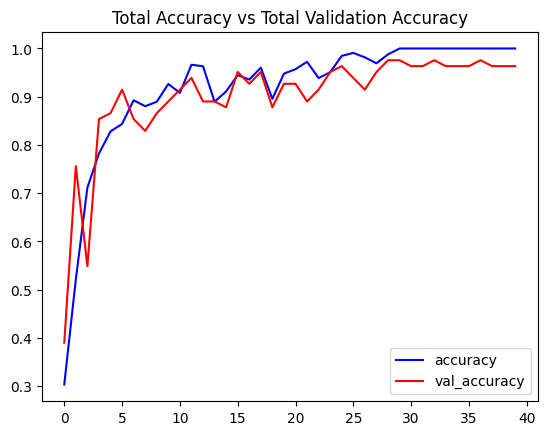

In [113]:

plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [114]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))


    frames_list = []

    predicted_class_name = ''

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)


    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    predicted_label = np.argmax(predicted_labels_probabilities)

    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()

In [116]:
input_video_file_path = 'test_videos/test2.mp4'
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

1/1 [==============================] - 0s 38ms/step
Action Predicted: MilitaryParade
Confidence: 0.9989357590675354
